In [3]:
import sigpy.plot as pl
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import scipy.io
from torch.autograd import Variable
% matplotlib notebook

In [5]:
import UFNet

In [6]:
mrf_dict = scipy.io.loadmat('/mikRAID/jtamir/projects/MRF_direct_contrast_synthesis/data/DictionaryAndSequenceInfo/fp_dictionary.mat')
# print(MRF_dic.keys())
fp_dict = mrf_dict['fp_dict']
t1_list = mrf_dict['t1_list']
t2_list = mrf_dict['t2_list']
N_dict = t1_list.shape[0]

In [7]:
def read_flipangles(flip_file):
    f = open(flip_file)
    flips =  [float(a) for a in f.readlines()]
    f.close()
    return np.array(flips)
flips = read_flipangles('/mikRAID/jtamir/projects/MRF_direct_contrast_synthesis/data/DictionaryAndSequenceInfo/flipangles.txt')
N_flip = len(flips)

In [8]:
fp_dic = np.hstack(list(fp_dict[0][0])).reshape((N_flip, 2, N_dict)).transpose((0, 2, 1))
fp_dic = np.abs(fp_dic[:,:,0] + 1j * fp_dic[:,:,1])
print(fp_dic.shape)

(500, 22031)


In [9]:
fp_train = fp_dic.transpose(1,0)[:,None,:]

In [10]:
fp_train.shape

(22031, 1, 500)

In [11]:
p = np.random.rand(22031,256)
p_norm = np.linalg.norm(p,axis=1)
p_normal = p/p_norm[None,:].T
B_tensor = torch.tensor(p_normal)
B_tensor_cuda = B_tensor.cuda()
fp_train_cuda = torch.tensor(fp_train).cuda()

In [11]:
# Here we train the network
n_dictionary = 22031
n_dimension = 256
tau = 0.07
def train_net(net,
              epochs=5,
              batch_size=1,
              lr=0.001):
    optimizer = torch.optim.SGD(net.parameters(), lr,
                                momentum=0.9,
                                weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_all = list([])
    for epoch in range(epochs):
        net.train()
        epoch_loss = 0
        print("Starting Epoch: %d" %(epoch+1))
        for index in range(n_dictionary):
            input_dic = fp_train_cuda[index,:,:].unsqueeze(0)
            output_dic = net(input_dic)
            
            
            ## error: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.
#             print(output_dic)
#             B_tensor_cuda.requires_grad = False
            output_dic1 = torch.mm(output_dic,B_tensor_cuda.detach().float().transpose(0,1))/tau
#             print(output_dic.requires_grad)
#             print(output_dic.shape)
            loss = criterion(output_dic1,torch.LongTensor([index]).cuda())
            if index % 1000 == 0:
                print(loss.item())
                loss_all.append(loss.item())
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            B_tensor_cuda[index,:] = output_dic
        print('Epoch finished ! Loss: {}'.format(epoch_loss / 22031))
        torch.save(net.state_dict(),
                           '/home/kewang/checkpoints_unf/' + 'CP{}.pth'.format(epoch + 1))
        np.save("loss_all.npy",np.array(loss_all))
        print('Checkpoint {} saved !'.format(epoch + 1))

In [12]:
net1 = UFNet.PixelNet(1).cuda()

In [16]:
# Here we train the network
n_dictionary = 22031
n_dimension = 256
tau = 0.07
epochs = 10000

net = UFNet.PixelNet(1).cuda()
optimizer = torch.optim.SGD(net.parameters(), 0.01,
                            momentum=0.9,
                            weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
loss_all = list([])
for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    optimizer.zero_grad()
    print("Starting Epoch: %d" %(epoch+1))
    for index in range(n_dictionary):
        input_dic = fp_train_cuda[index,:,:].unsqueeze(0)
        output_dic = net(input_dic)


        ## error: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.
#             print(output_dic)
#             B_tensor_cuda.requires_grad = False
        output_dic1 = torch.mm(output_dic,B_tensor_cuda.detach().float().transpose(0,1))/tau
#             print(output_dic.requires_grad)
#             print(output_dic.shape)
        loss = criterion(output_dic1,torch.LongTensor([index]).cuda())
        loss.backward()
        if index >1:
            if index % 3000 == 0:
#                 optimizer.zero_grad()
                optimizer.step()
                optimizer.zero_grad()
            if index % 1000 == 0:
                print(loss.item())
                loss_all.append(loss.item())
        epoch_loss += loss.item()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         B_tensor_cuda[index,:] = output_dic
#                     optimizer.step()
#     optimizer.zero_grad()
    for index in range(n_dictionary):
        input_dic = fp_train_cuda[index,:,:].unsqueeze(0)
        output_dic = net(input_dic)
        B_tensor_cuda[index,:] = output_dic


#         ## error: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.
# #             print(output_dic)
# #             B_tensor_cuda.requires_grad = False
#         output_dic1 = torch.mm(output_dic,B_tensor_cuda.detach().float().transpose(0,1))/tau
# #             print(output_dic.requires_grad)
# #             print(output_dic.shape)
#         loss = criterion(output_dic1,torch.LongTensor([index]).cuda())
#         loss.backward()
#         if index >1:
#             if index % 5000 == 0:
# #                 optimizer.zero_grad()
#                 optimizer.step()
#                 optimizer.zero_grad()
#             if index % 1000 == 0:
#                 print(loss.item())
#                 loss_all.append(loss.item())
#         epoch_loss += loss.item()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         B_tensor_cuda[index,:] = output_dic
    print('Epoch finished ! Loss: {}'.format(epoch_loss / 22031))
    torch.save(net.state_dict(),
                       '/home/kewang/checkpoints_unf/' + 'CP{}.pth'.format(epoch + 1))
    np.save("loss_all.npy",np.array(loss_all))
    print('Checkpoint {} saved !'.format(epoch + 1))

Starting Epoch: 1
9.390752792358398
10.404566764831543
10.159347534179688
9.660727500915527
9.408712387084961
11.13088321685791
10.303200721740723
10.754667282104492
10.035898208618164
9.960761070251465
9.790356636047363
9.42021656036377
10.336142539978027
10.48243522644043
10.370478630065918
10.765872955322266
10.452048301696777
10.24783992767334
10.833239555358887
10.595870018005371
10.627049446105957
9.301441192626953
Epoch finished ! Loss: 10.125021684305585
Checkpoint 1 saved !
Starting Epoch: 2
10.000205993652344
10.000205039978027
10.000205039978027
10.00020694732666
10.000203132629395
10.00020694732666
10.00020694732666
10.00020694732666
10.000205039978027
10.000205039978027
10.000205993652344
10.000205039978027
10.000205039978027
10.000205039978027
10.000204086303711
10.000204086303711
10.000204086303711
10.000205039978027
10.000203132629395
10.000205993652344
10.000205993652344
10.000205039978027


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


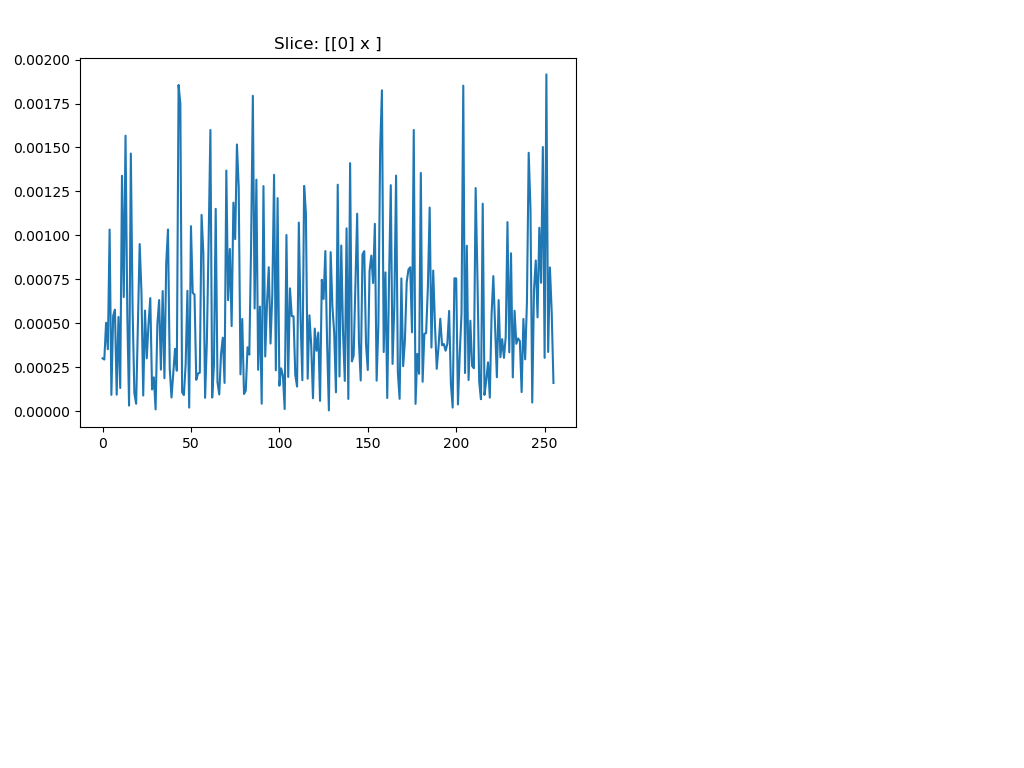

NameError: name 'tau' is not defined

In [13]:
input_dic = fp_train_cuda[2000,:,:].unsqueeze(0)
output_dic = net1(input_dic)
input_dic2 = fp_train_cuda[1000,:,:].unsqueeze(0)
output_dic2 = net1(input_dic2)
b = output_dic.detach().cpu().numpy() - output_dic2.detach().cpu().numpy()
pl.LinePlot(b)
        ## error: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.
#             print(output_dic)
#             B_tensor_cuda.requires_grad = False
output_dic1 = torch.mm(output_dic,B_tensor_cuda.detach().float().transpose(0,1))/tau
#             print(output_dic.requires_grad)
#             print(output_dic.shape)
loss = criterion(output_dic1,torch.LongTensor([1000]).cuda())

In [37]:
loss.item()

8.09029769897461

<IPython.core.display.Javascript object>


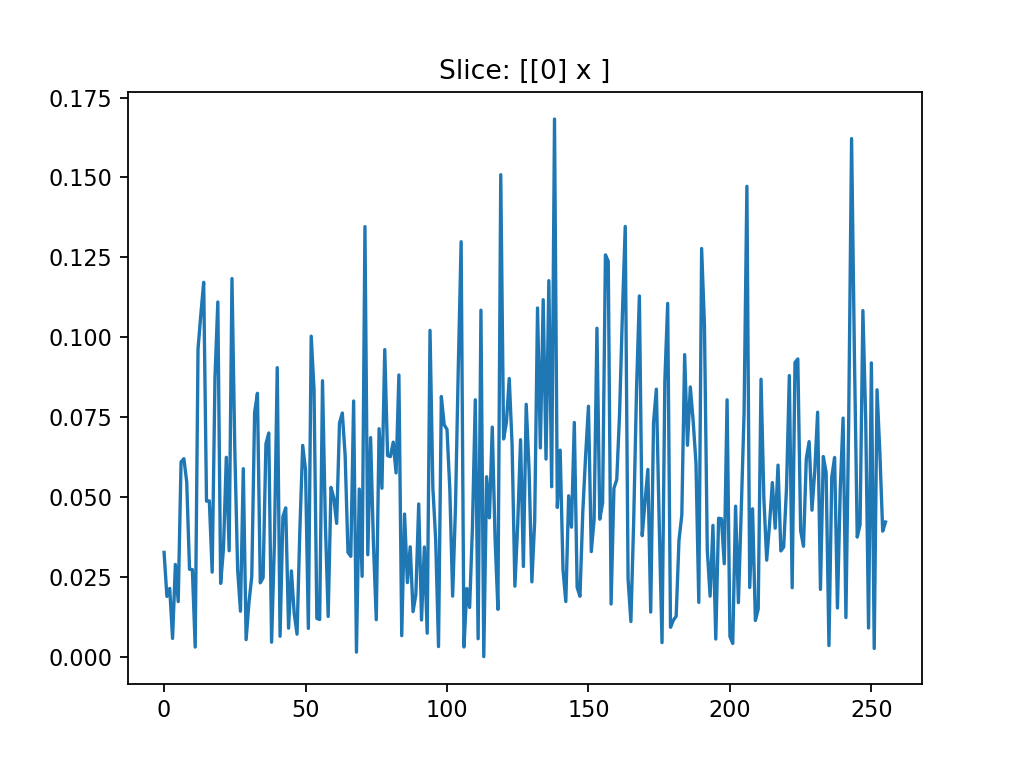

In [44]:
input_dic_test = fp_train_cuda[10000,:,:].unsqueeze(0)
output_dic_test = net(input_dic_test)
pl.LinePlot(output_dic_test.detach().cpu().numpy())
output_dic1_test = torch.mm(output_dic_test,B_tensor_cuda.detach().float().transpose(0,1))/tau
loss = cc(output_dic1_test,torch.LongTensor([20000]).cuda())
# output_dic1_test = torch.mm(output_dic_test,B_tensor_cuda.detach().float().transpose(0,1))/tau

In [43]:
loss

tensor(11.4399, device='cuda:0', grad_fn=<NllLossBackward>)

In [441]:
net_uf = UFNet.PixelNet(1)

In [442]:
net_ufcuda = net_uf.cuda()

In [289]:
input_dic_test = fp_train_cuda[500,:,:].unsqueeze(0)
output_dic_test = net_ufcuda(input_dic_test)
output_dic1_test = torch.mm(output_dic_test,B_tensor_cuda.detach().float().transpose(0,1))/tau

In [25]:
cc = nn.CrossEntropyLoss()

In [292]:
loss = cc(output_dic1_test,torch.LongTensor([500]).cuda())

In [478]:
fp_train.shape

(22031, 1, 500)

In [520]:
nt = UFNet.PixelNet(1)
nt.load_state_dict(torch.load("../checkpoints_unf/CP28.pth"))
nt0 = nt.cuda()
input_dic_test = fp_train_cuda[0,:,:].unsqueeze(0)
output_dic_test = net_ufcuda(input_dic_test)
output_dic1_test = torch.mm(output_dic_test,B_tensor_cuda.detach().float().transpose(0,1))/tau
loss = cc(output_dic1_test,torch.LongTensor([10000]).cuda())
# pl.LinePlot(B_tensor_cuda[5000,:].detach().cpu().float().numpy())

In [521]:
output_dic_test

tensor([[-0.0278, -0.0461, -0.0051, -0.0124, -0.0692,  0.0511,  0.0777,  0.0511,
          0.0567, -0.0022,  0.0076,  0.0045,  0.0049,  0.0321,  0.1048,  0.0309,
          0.0544, -0.0074, -0.0242,  0.0515,  0.0363,  0.0095,  0.0489,  0.0086,
          0.0490,  0.0192, -0.0337, -0.0077,  0.0684, -0.0242,  0.0626,  0.0815,
          0.0052,  0.0565, -0.0044,  0.0338,  0.0278,  0.0514, -0.0107,  0.1118,
         -0.0688, -0.0089, -0.0039,  0.0122,  0.1443,  0.1217,  0.0898,  0.0593,
          0.0437, -0.0194,  0.0074,  0.0447,  0.0516, -0.0468,  0.0496, -0.0541,
          0.0405,  0.1281, -0.0651, -0.0795,  0.0337,  0.0210, -0.0542, -0.0216,
          0.1200,  0.0169, -0.0289,  0.0526,  0.0012, -0.0061, -0.0118,  0.0770,
          0.1753,  0.0779,  0.1007,  0.0489,  0.0584, -0.0285,  0.0304, -0.0060,
          0.0087,  0.0344,  0.0186,  0.0361,  0.0037, -0.0170,  0.0988, -0.0226,
          0.1394,  0.0632, -0.0258,  0.0235,  0.0228,  0.0115,  0.0344, -0.0147,
         -0.0226,  0.0684,  

In [438]:
output_dic1_test.max()*tau

tensor(0.9967, device='cuda:0', grad_fn=<MulBackward0>)

In [439]:
B_tensor_cuda = B_tensor.cuda()

In [444]:
train_net(net_ufcuda,1000,1,0.03)

Starting Epoch: 1
11.231678009033203
6.898996353149414
6.962409019470215
6.873554229736328
6.893313407897949
6.816213607788086
6.804896354675293
5.760597229003906
5.20340633392334
5.425529479980469
5.1975555419921875
6.687837600708008
6.51987361907959
9.288898468017578
9.767376899719238
10.115033149719238
10.125466346740723
10.593745231628418
10.194001197814941
10.508931159973145
10.978161811828613
10.783696174621582
10.766740798950195
Epoch finished ! Loss: 8.061122632038577
Checkpoint 1 saved !
Starting Epoch: 2
20.588075637817383
5.318092346191406
6.355125427246094
6.360411643981934
6.7966413497924805
6.87518310546875
6.898260116577148
8.844487190246582
11.861841201782227
11.217596054077148
11.457673072814941
9.812807083129883
8.857461929321289
9.452831268310547
8.689266204833984
8.37021255493164
8.110657691955566
7.9531755447387695
7.798953056335449
7.5826005935668945
7.615848541259766
6.850124359130859
6.64406681060791
Epoch finished ! Loss: 7.967492470008192
Checkpoint 2 saved !


6.365297317504883
6.355071067810059
6.367959022521973
6.337217330932617
6.332459449768066
6.330414772033691
6.328373908996582
6.32525634765625
6.328667640686035
Epoch finished ! Loss: 6.362062752996278
Checkpoint 17 saved !
Starting Epoch: 18
6.329401969909668
6.345732688903809
6.342577934265137
6.359404563903809
6.3367109298706055
6.330753326416016
6.333625793457031
6.325104713439941
6.32119083404541
6.317575454711914
6.315333366394043
6.328916549682617
6.3058671951293945
6.315369606018066
6.3177385330200195
6.3071441650390625
6.322414398193359
6.28521728515625
6.281154632568359
6.278294563293457
6.278702735900879
6.273176193237305
6.274415969848633
Epoch finished ! Loss: 6.314306086956262
Checkpoint 18 saved !
Starting Epoch: 19
6.274829864501953
6.291385650634766
6.278451919555664
6.302734375
6.277644157409668
6.272641181945801
6.275668144226074
6.269293785095215
6.264781951904297
6.264098167419434
6.264013290405273
6.273113250732422
6.257872581481934
6.262814521789551
6.26803302764

KeyboardInterrupt: 

In [239]:
np.save("bank_003.npy",B_tensor_cuda.detach().cpu().numpy())

In [18]:
load = np.load("../unsupervised_fingerprinting/Bank.npy")

<IPython.core.display.Javascript object>


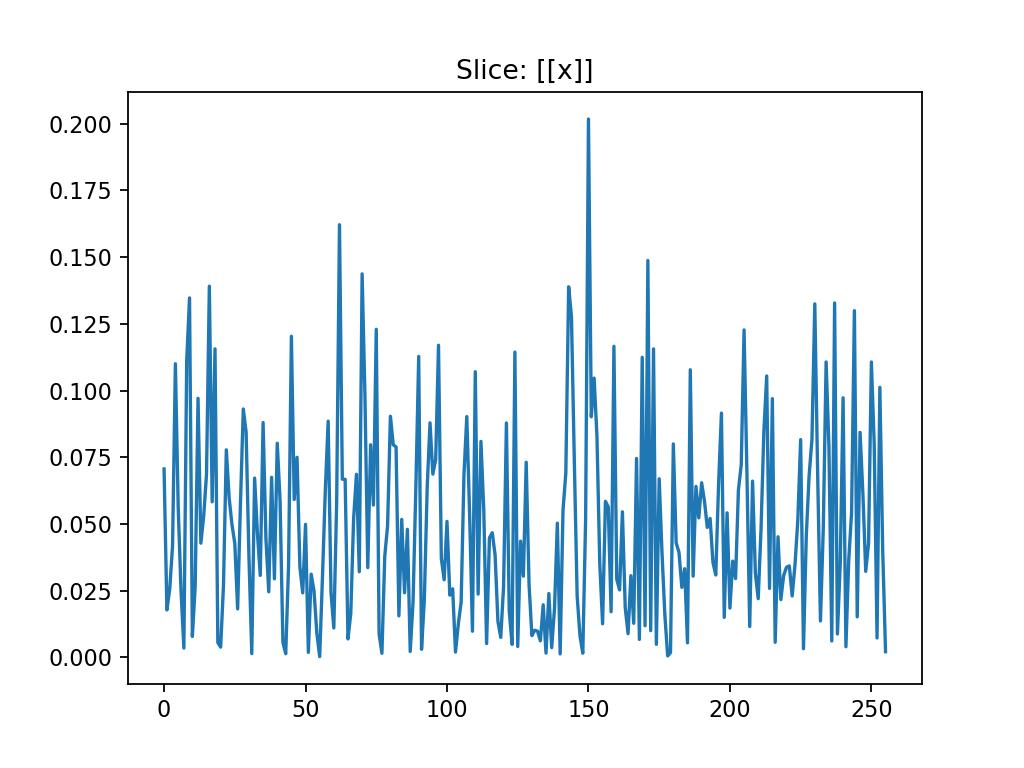

In [22]:
pl.LinePlot(load[100,:])

In [319]:
MRF_data = np.load("/home/kewang/Pytorch-UNet/data/augmented_data/MRF/MRF_norm_volunteer9_4.npy")

In [320]:
T1_mapping = np.load("/home/kewang/Pytorch-UNet/Fingerprinting/DictionaryAndSequenceInfo/T1_mapping.npy")
T2_mapping = np.load("/home/kewang/Pytorch-UNet/Fingerprinting/DictionaryAndSequenceInfo/T2_mapping.npy")

In [321]:
MRF_data.shape

(1000, 320, 320)

In [ ]:
pl.LinePlot()

In [406]:
signal = MRF_data[:,100,100]

In [407]:
SP_real = signal[:500][None,None,:]
SP_image = signal[500:][None,None,:]

In [408]:
SP = np.concatenate((SP_real,SP_image),1)

<IPython.core.display.Javascript object>


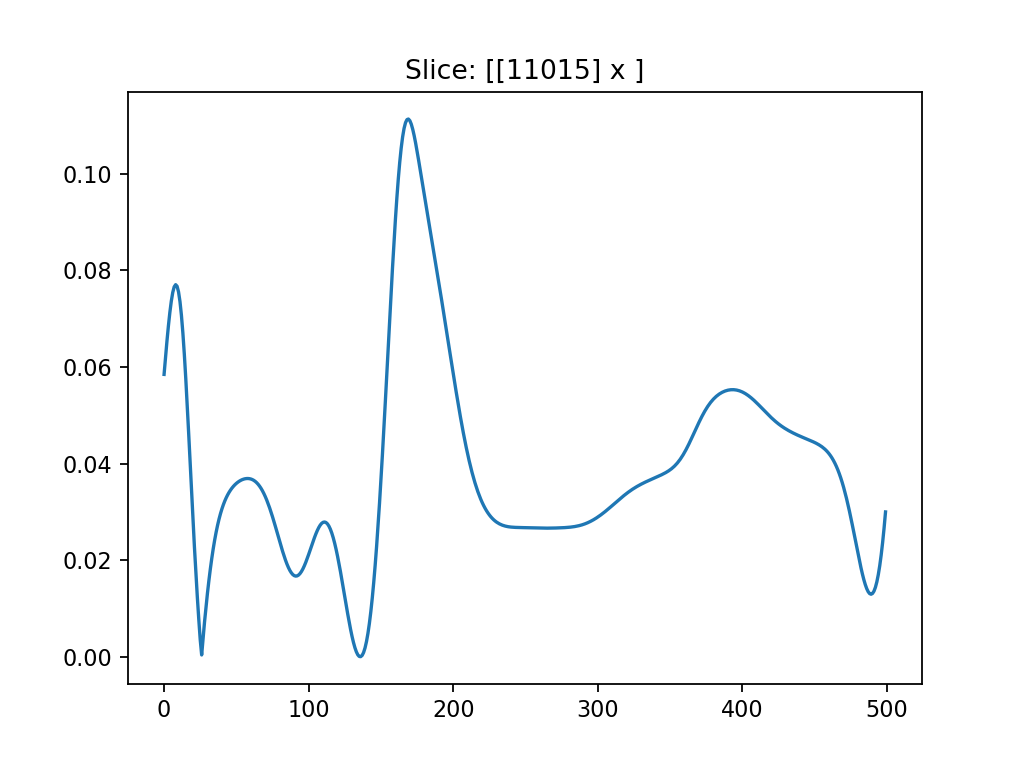

In [416]:
pl.LinePlot(fp_train[:,0,:]+1j*fp_train[:,1,:])

In [410]:
SP_t = torch.tensor(SP).cuda()

In [411]:
output_sp = nt0(SP_t)

In [412]:
output_sp1 = torch.mm(output_sp,B_tensor_cuda.detach().float().transpose(0,1))

In [413]:
output_sp1.shape

torch.Size([1, 22031])

In [414]:
output_sp1.argmax()

tensor(1126, device='cuda:0')

In [374]:
t1_t2_list = np.hstack((t1_list, t2_list)) # ms

In [380]:
t1_t2_list[1126,0]

96

In [377]:
T2_mapping[100,100]

98.0

<IPython.core.display.Javascript object>


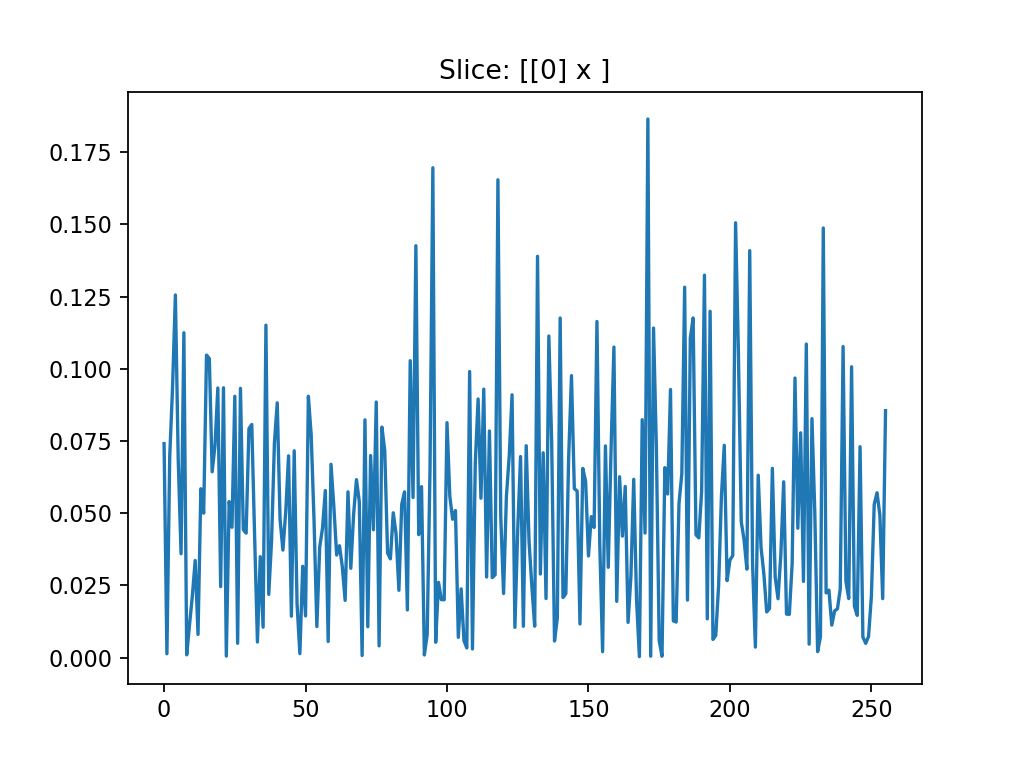

In [332]:
pl.LinePlot(output_sp.detach().cpu().numpy())

<IPython.core.display.Javascript object>


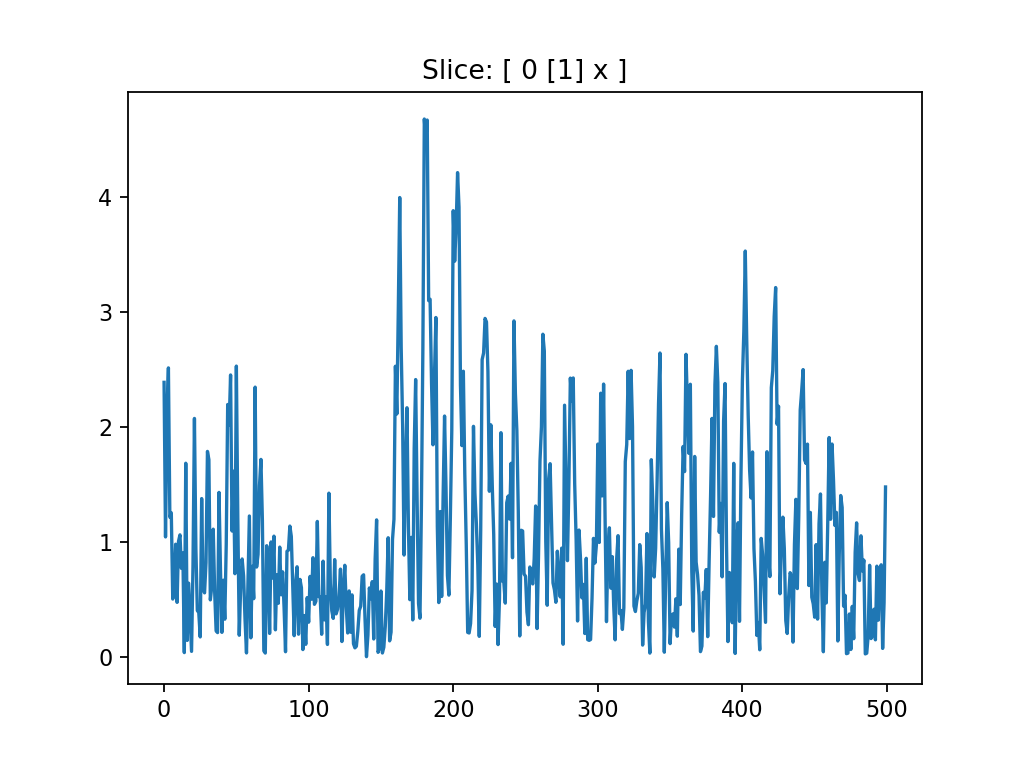

In [328]:
pl.LinePlot(SP)